--------------------------------------------------------------

## **Bayesian Deep Learning & Estimating Uncertainty**

--------------------------------------------------------------

Performances of Deep Neural Networks (DNNs) rely on the ability to progressively build and extract features from large data. Though these deep models are usually adaptive the performance depends on the data distribution. The robustness property is important in various applications such as computer vision tasks, eg. autonomous driving, because the outdoor environments may naturally vary. One thing at this point we would desire is to **know how likely the predictions are going to be correct, and this can be done by incorporating uncertainty estimation within the model**.

One of the easiest to ways to get started with different types of uncertainties is to think about reducible and irreducible uncertainties.

**_Aleatoric (aka Statistical) Uncertainty_:** *captures noise inherent in the observations*. This could be for example sensor noise or motion noise, resulting in uncertainty **which cannot be reduced** even if more data were to be collected. 

**_Epistemic (aka Systematic) Uncertainty_:** *accounts for uncertainty in the model parameters*. This uncertainty captures insufficiency or ignorance/negligence about certain aspects in our collected data. This uncertainty **can be explained away given enough data**, and is often referred to as model uncertainty.

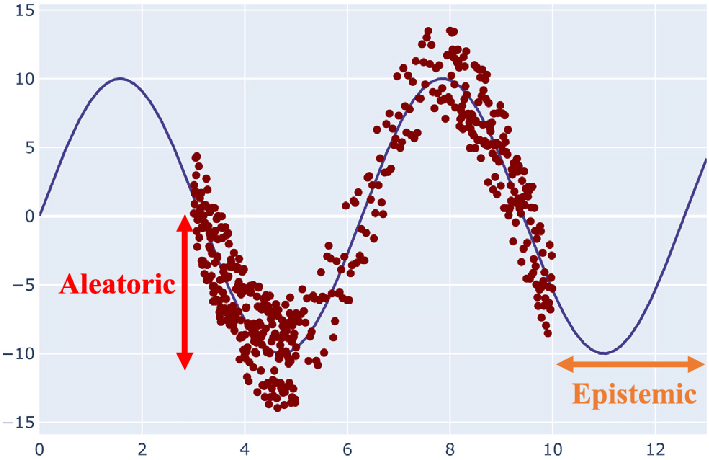

**These uncertainties are formalized as probability distributions over either the model parameters (for Epistemic Uncertainty), or model outputs (for Aleatoric Uncertainty).** Epistemic uncertainty is modeled by placing a prior distribution over a model’s weights, and then trying to capture how much these weights vary given some data. Aleatoric uncertainty on the other hand is modeled by placing a distribution over the output of the model. 

--------------------------------------------------------------

## **Bayesian Neural Networks (BNNs) - Capturing Uncertainty**

--------------------------------------------------------------

**To capture epistemic uncertainty** in a neural network $(NN)$ we put a prior distribution over its weights, for example a Gaussian prior distribution: $W ∼ \mathcal{N} (0, I)$.

Such a model is referred to as a *Bayesian Neural Network (BNN)*. Bayesian neural networks **replace the deterministic network’s weight parameters with distributions over these parameters, and instead of optimising the network weights directly, we average over all possible weights** (referred to as marginalization). Denoting the random output of the BNN as $f^{W}(x)$, we define the model likelihood $p\left(y|f^{W}(x)\right)$. Given a dataset $X = \{x_1, ..., x_N\},\, Y=\{y_1,\, \ldots , y_N\}$, Bayesian inference
is used to compute the posterior over the weights $p(W|X, Y)$. This posterior captures the set of plausible model parameters, given the data. For regression tasks we often define our likelihood as a Gaussian with mean given by the model
output: $p(y|f^{W}(x)) = \mathcal{N} \left(f^W(x), \sigma^2\right)$, with an observation noise scalar parameter $\sigma$.

BNNs are are easy to formulate, but difficult to perform inference in. This is because the marginal probability $p(Y|X)$ required to evaluate the posterior $p(W|X, Y)= \frac{p(Y|X,W) \cdot p(W)}{p(Y|X)}$ cannot be evaluated analytically. However, different methods exist to capture epistemic uncertainty (model parameter uncertainty), by approximating the distribution $p(W|X, Y)$.

---

**To capture aleatoric uncertainty** in regression, we would have to tune the observation noise parameter $σ$. **Homoscedastic regression** assumes constant observation noise $\sigma$ for every input point $x$. **Heteroscedastic regression**, on the other hand, assumes that observation noise can vary with input $x$. Heteroscedastic models are useful in cases where parts of the observation space might have higher noise levels than others.

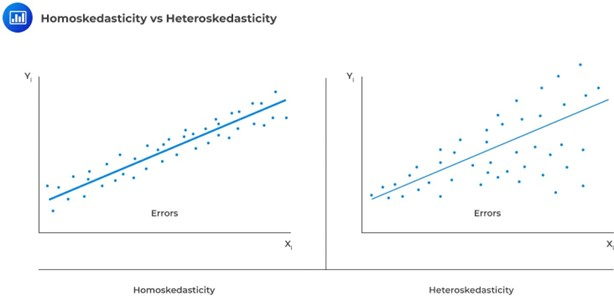

------------------------------------------------------

In [105]:
import os
import ntpath
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

In [73]:
#@title Import { display-mode: "form" }
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.reset_defaults()
#sns.set_style('whitegrid')
#sns.set_context('talk')
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions
sns.set_context(context='talk',font_scale=0.7)
%matplotlib inline

In [21]:
# Define data directory
data_directory = 'AutoDRIVE-Nigel-Dataset/straight_30_hz/'

In [22]:
def shorten_path(path):
    '''
    Function to view shortened paths.
    '''
    head,tail = ntpath.split(path)
    return tail

In [56]:
# Read the driving log
headers = ['timestamp','throttle','steering','leftTicks','rightTicks','posX','posY','posZ','roll','pitch','yaw','speed','angX','angY','angZ','accX','accY','accZ','cam0','cam1','lidar']

# Read each CSV file in dir "path/to/root_dir"
vehicle_logs = []
for file in Path(data_directory).glob("**/*.csv"):
    vehicle_logs.append(pd.read_csv(file, names=headers))

# Train test split
train_size = int(len(vehicle_logs)*0.8)
train_logs = vehicle_logs[:train_size]
test_logs = vehicle_logs[train_size+1:]

# Put the dataframes to a single dataframe
vehicle_log = pd.concat(vehicle_logs)
train_log = pd.concat(train_logs)
test_log = pd.concat(test_logs)

#vehicle_log = pd.read_csv(file_path)

#vehicle_log = pd.read_csv(os.path.join(data_directory,'Driving-Log.csv'), names = headers)
#pd.set_option('display.max_colwidth', -1)

# Convert timestamp from string to datetime format
vehicle_log['timestamp'] = pd.to_datetime(vehicle_log['timestamp'], format='%Y_%m_%d_%H_%M_%S_%f')

# Shorten camera frame paths
vehicle_log['cam0'] = vehicle_log['cam0'].apply(shorten_path)
vehicle_log['cam1'] = vehicle_log['cam1'].apply(shorten_path)

# View the first 5 entries in the dataframe
vehicle_log.head()

,timestamp,throttle,steering,leftTicks,rightTicks,posX,posY,posZ,roll,pitch,...,speed,angX,angY,angZ,accX,accY,accZ,cam0,cam1,lidar
0,2023-04-26 21:09:55.567,0.0,0,0,0,8.940697e-07,-1.435360e-09,0.032498,-2.392900e-07,-1.276300e-08,...,0.0,2.933082e-07,0.000009,2.670090e-10,-9.842642e-05,2.184563e-07,0.0,Camera0_Frame_2023_04_26_21_09_55_567.jpg,Camera1_Frame_2023_04_26_21_09_55_567.jpg,inf inf inf inf inf inf inf inf inf inf inf in...
1,2023-04-26 21:09:55.607,0.0,0,0,0,8.940697e-07,-1.278782e-09,0.032498,2.751419e-08,-1.283946e-08,...,0.0,-2.108585e-07,-0.000005,8.599332e-11,3.620926e-08,2.311502e-07,0.0,Camera0_Frame_2023_04_26_21_09_55_607.jpg,Camera1_Frame_2023_04_26_21_09_55_607.jpg,inf inf inf inf inf inf inf inf inf inf inf in...
2,2023-04-26 21:09:55.649,0.0,0,0,0,8.940697e-07,-1.281219e-09,0.032498,-1.500774e-08,-1.283458e-08,...,0.0,3.484426e-08,-0.000006,8.443595e-11,4.180833e-08,2.312346e-07,0.0,Camera0_Frame_2023_04_26_21_09_55_649.jpg,Camera1_Frame_2023_04_26_21_09_55_649.jpg,inf inf inf inf inf inf inf inf inf inf inf in...
3,2023-04-26 21:09:55.698,0.0,0,0,0,8.940697e-07,-1.317854e-09,0.032498,-4.085440e-08,-1.283459e-08,...,0.0,2.546526e-07,-0.000006,5.591394e-11,2.611955e-08,2.047944e-07,0.0,Camera0_Frame_2023_04_26_21_09_55_698.jpg,Camera1_Frame_2023_04_26_21_09_55_698.jpg,inf inf inf inf inf inf inf inf inf inf inf in...
4,2023-04-26 21:09:55.738,0.0,0,0,0,8.940697e-07,-1.321890e-09,0.032498,-2.668042e-08,-1.284029e-08,...,0.0,1.282504e-07,-0.000007,8.430723e-11,4.678213e-08,2.316831e-07,0.0,Camera0_Frame_2023_04_26_21_09_55_738.jpg,Camera1_Frame_2023_04_26_21_09_55_738.jpg,inf inf inf inf inf inf inf inf inf inf inf in...


In [24]:
# Reset initial timestamp to zero and update thereafter in microseconds
# vehicle_log['microseconds'] = vehicle_log['timestamp'].dt.microsecond
# vehicle_log['microseconds'] = (vehicle_log['microseconds'].apply(lambda x: round(x, -3)))/1000
# vehicle_log['seconds'] = vehicle_log['timestamp'].dt.second
# vehicle_log['minute'] = vehicle_log['timestamp'].dt.minute
# vehicle_log['time'] =  vehicle_log['microseconds'] + (vehicle_log['seconds'] * 1000) + (vehicle_log['seconds'] * 60 * 1000)-25000 - 1500000
# vehicle_log['time_diff'] = (vehicle_log['time'].diff())
# vehicle_log['time_diff'].iloc[0] = 0
# vehicle_log['elapsed_time'] = vehicle_log['time_diff'].cumsum()
# del vehicle_log[vehicle_log.columns[-2]]
# del vehicle_log[vehicle_log.columns[-2]]
# del vehicle_log[vehicle_log.columns[-2]]
# del vehicle_log[vehicle_log.columns[-2]]
# del vehicle_log[vehicle_log.columns[-2]]
# vehicle_log.head()

<Axes: xlabel='Timestamp', ylabel='Speed (m/s)'>

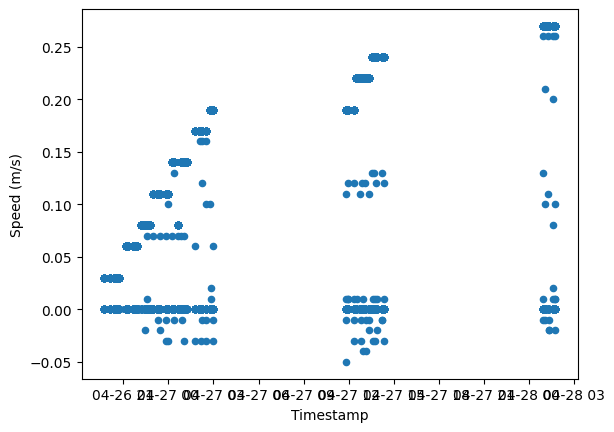

In [51]:
vehicle_log.plot(x='timestamp', y='speed', kind='scatter', xlabel='Timestamp', ylabel='Speed (m/s)', legend=False)	

<Axes: xlabel='Timestamp', ylabel='Throttle (norm%)'>

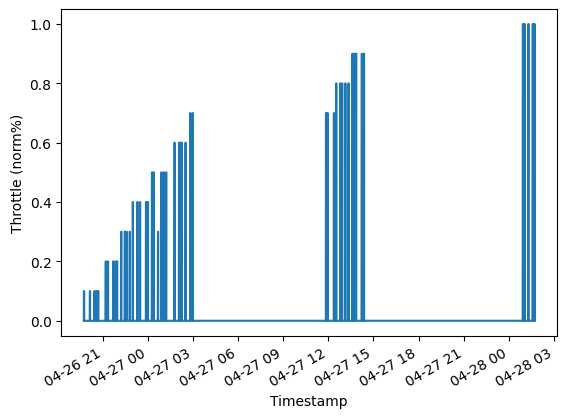

In [26]:
vehicle_log.plot(x='timestamp', y='throttle', kind='line', xlabel='Timestamp', ylabel='Throttle (norm%)', legend=False)	

<Axes: xlabel='Timestamp', ylabel='Steering (rad)'>

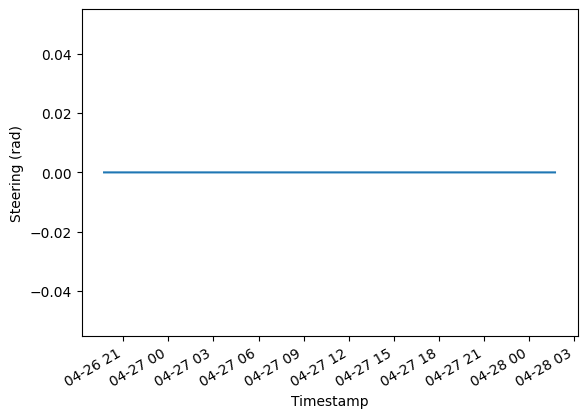

In [27]:
vehicle_log.plot(x='timestamp', y='steering', kind='line', xlabel='Timestamp', ylabel='Steering (rad)', legend=False)	

(-1.171098561226815, 24.593089455296514, -0.000179979338585, 0.003777246920885)

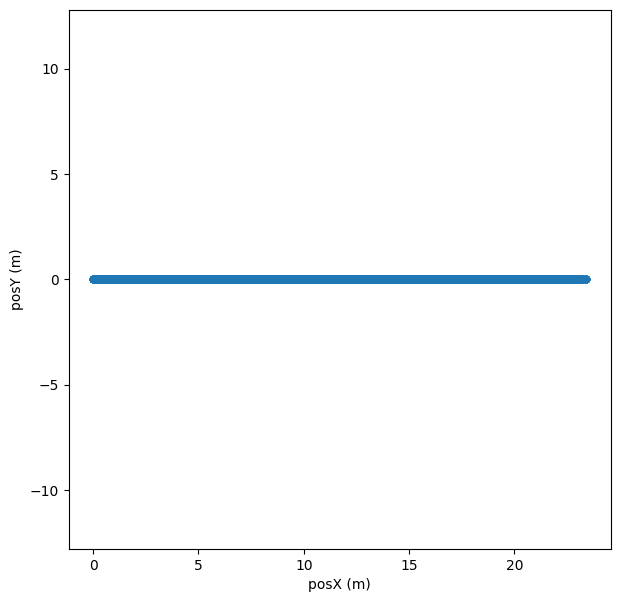

In [45]:
figsize=(20, 20)
vehicle_log.plot(x='posX', y='posY', kind='scatter', xlabel='posX (m)', ylabel='posY (m)', legend=False, figsize=(7, 7))
plt.axis('equal')

<Axes: xlabel='Timestamp', ylabel='posY (m/s)'>

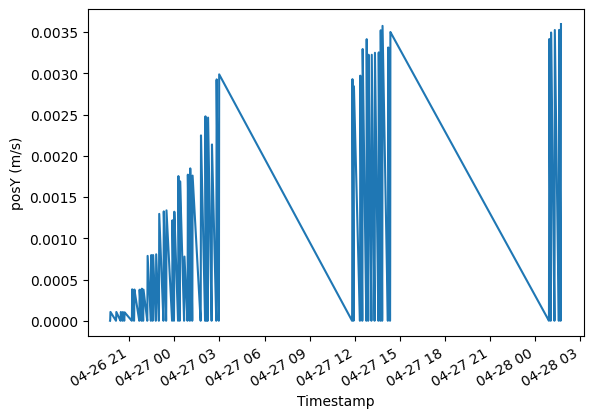

In [44]:
vehicle_log.plot(x='timestamp', y='posY', kind='line', xlabel='Timestamp', ylabel='posY (m/s)', legend=False)

<Axes: xlabel='Timestamp', ylabel='posX (m)'>

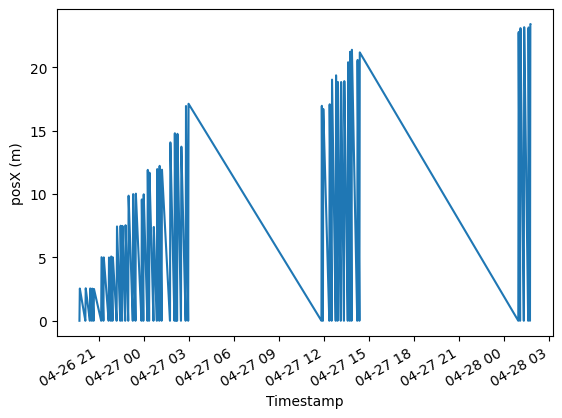

In [30]:
vehicle_log.plot(x='timestamp', y='posX', kind='line', xlabel='Timestamp', ylabel='posX (m)', legend=False)

<Axes: xlabel='Timestamp', ylabel='angZ (rad/s)'>

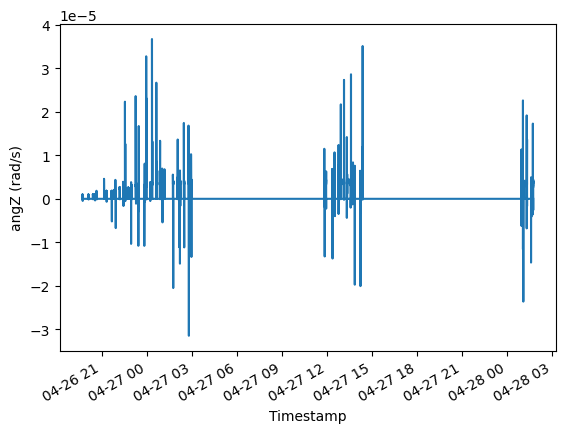

In [31]:
vehicle_log.plot(x='timestamp', y='angZ', kind='line', xlabel='Timestamp', ylabel='angZ (rad/s)', legend=False)

<Axes: xlabel='Timestamp', ylabel='yaw (rad)'>

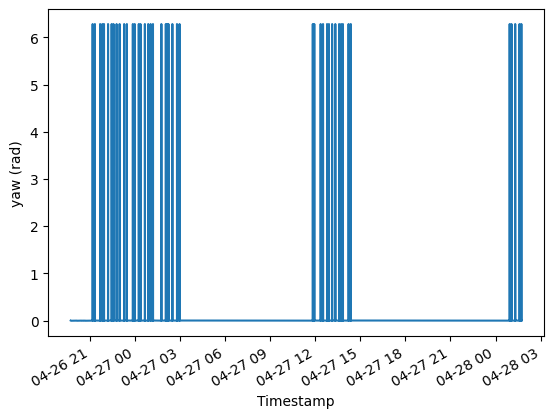

In [32]:
vehicle_log.plot(x='timestamp', y='yaw', kind='line', xlabel='Timestamp', ylabel='yaw (rad)', legend=False)

(14001, 21)

In [99]:
def load_dataset():
  x_train = train_log['throttle']
  y_train = train_log['speed']
  x_test = test_log['throttle']
  y_test = test_log['speed']
  return x_train.to_numpy(), y_train.to_numpy(), x_test.to_numpy(), y_test.to_numpy()

x_train, y_train, x_test, y_test = load_dataset()

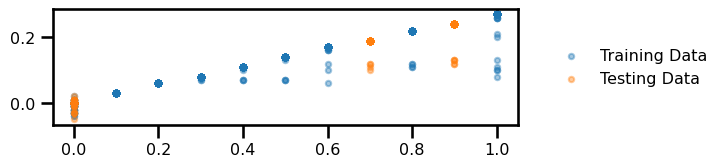

In [100]:
# Set figure size
plt.figure(figsize=(6, 1.5))
# Plot training data
plt.scatter(x_train, y_train, s=15, label="Training Data", alpha=0.4)
plt.scatter(x_test, y_test, s=15, label="Testing Data", alpha=0.4)
# Add legend and show the plot
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))
plt.show()

In [101]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

In [102]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

In [ ]:
# Build model.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable, kl_weight=1/x_train.shape[0]),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

# Do inference.
nll_loss = lambda y, rv_y: -rv_y.log_prob(y)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=nll_loss)
model.fit(x_train, y_train, epochs=10, verbose=True);

In [ ]:
# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_test)
assert isinstance(yhat, tfp.distributions.Distribution)

In [104]:
# Define the prior weight distribution -- all N(0, 1) and not trainable
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = Sequential([
        tfp.layers.DistributionLambda(lambda t : tfd.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n))),
    ])
    return prior_model

# Define the variational posterior weight distribution -- Multivariate Gaussian
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = Sequential([
        tfp.layers.VariableLayer(tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfp.layers.MultivariateNormalTriL(n)
    ])
    return posterior_model

# Define the negative log likelihood loss function
def nll_loss(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [106]:
# Create probabilistic regression with one hidden layer weight uncertainty
model = Sequential([
    tfp.layers.DenseVariational(units=8,
                          input_shape=(1, ),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x_train.shape[0],
                          activation='sigmoid'),

    Dense(16, activation='tanh'),
    Dense(32, activation='tanh'),
    Dense(16, activation='tanh'),
    Dense(8, activation='tanh'),
    
    tfp.layers.DenseVariational(units=tfp.layers.IndependentNormal.params_size(1),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x_train.shape[0]),
    tfp.layers.IndependentNormal(1)
])

model.compile(loss=nll_loss, optimizer=RMSprop(learning_rate=0.01))
model.summary()

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational_7 (DenseV  (None, 8)                152       
 ariational)                                                     
                                                                 
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                              

In [107]:
# Train the model
model.fit(x_train, y_train, epochs=10, verbose=True)
model.evaluate(x_train, y_train)

Epoch 1/10
1895/1895 [==============================] - 26s 13ms/step - loss: 35.4475
Epoch 2/10
1895/1895 [==============================] - 23s 12ms/step - loss: -0.4280
Epoch 3/10
1895/1895 [==============================] - 23s 12ms/step - loss: -0.4704
Epoch 4/10
1895/1895 [==============================] - 22s 12ms/step - loss: -0.5838
Epoch 5/10
1895/1895 [==============================] - 22s 12ms/step - loss: -0.5991
Epoch 6/10
1895/1895 [==============================] - 23s 12ms/step - loss: -0.5294
Epoch 7/10
1895/1895 [==============================] - 23s 12ms/step - loss: -0.5980
Epoch 8/10
1895/1895 [==============================] - 23s 12ms/step - loss: -0.5639
Epoch 9/10
1895/1895 [==============================] - 22s 12ms/step - loss: -0.6120
Epoch 10/10
1895/1895 [==============================] - 10s 5ms/step - loss: -0.9141


-0.9140632152557373

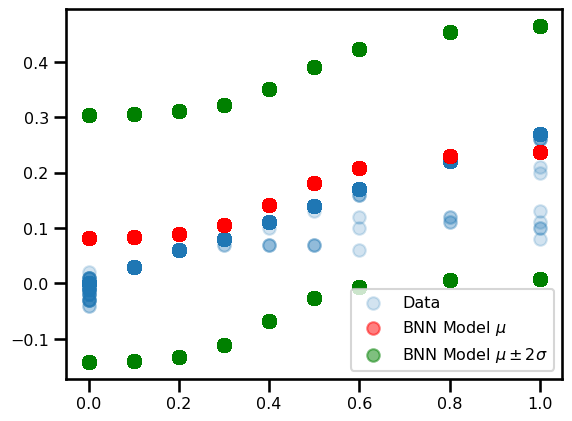

In [116]:
# Plot an ensemble of trained probabilistic regressions
plt.scatter(x_train, y_train, alpha=0.2, label='Data')
for _ in range(1):
    y_model = model(x_train)
    y_hat = y_model.mean()
    y_hat_m2std = y_hat - 2 * y_model.stddev()
    y_hat_p2std = y_hat + 2 * y_model.stddev()
    if _ == 0:
        plt.scatter(x_train, y_hat, color='red', alpha=0.5, label='BNN Model $\mu$')
        plt.scatter(x_train, y_hat_m2std, color='green', alpha=0.5, label='BNN Model $\mu \pm 2 \sigma$')
        plt.scatter(x_train, y_hat_p2std, color='green', alpha=0.5)
    else:
        plt.scatter(x_train, y_hat, color='red', alpha=0.5)
        plt.scatter(x_train, y_hat_m2std, color='green', alpha=0.5)
        plt.scatter(x_train, y_hat_p2std, color='green', alpha=0.5)
plt.legend(loc='best')
plt.show()

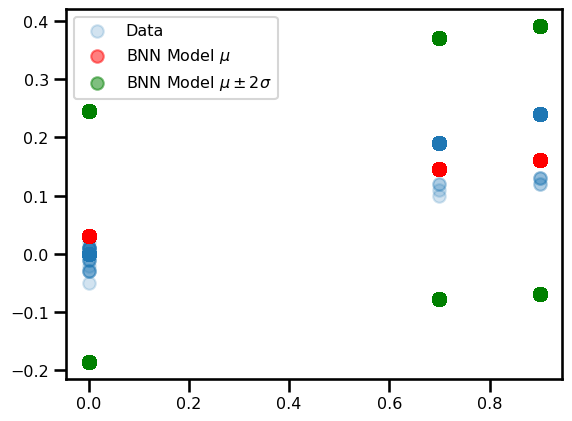

In [117]:
# Plot an ensemble of trained probabilistic regressions
plt.scatter(x_test, y_test, alpha=0.2, label='Data')
for _ in range(1):
    y_model = model(x_test)
    y_hat = y_model.mean()
    y_hat_m2std = y_hat - 2 * y_model.stddev()
    y_hat_p2std = y_hat + 2 * y_model.stddev()
    if _ == 0:
        plt.scatter(x_test, y_hat, color='red', alpha=0.5, label='BNN Model $\mu$')
        plt.scatter(x_test, y_hat_m2std, color='green', alpha=0.5, label='BNN Model $\mu \pm 2 \sigma$')
        plt.scatter(x_test, y_hat_p2std, color='green', alpha=0.5)
    else:
        plt.scatter(x_test, y_hat, color='red', alpha=0.5)
        plt.scatter(x_test, y_hat_m2std, color='green', alpha=0.5)
        plt.scatter(x_test, y_hat_p2std, color='green', alpha=0.5)
plt.legend(loc='best')
plt.show()